# Introduction


## Problem statement


Singlife has observed a concerning trend in the customer journey: potential policyholders are expressing hesitation and eventual disengagement during the insurance acquisition process. To address this, Singlife seeks to leverage its dataset. The objective is to <font size="4">**derive actionable insights from this data to enhance the customer experience**</font>. The challenge is to dissect the dataset to <font size="4">**uncover the critical touchpoints that contribute to customer drop-off and identify opportunities to streamline the application process and personalize communication**</font>. The ultimate goal is to <font size="4">**predict customer satisfaction and conversion rates, thereby bolstering Singlife's market position**</font>.


## Selected variables


<strong><h5>1. General Client Information</h5></strong>

1. `clntnum`
2. `ctrycode_desc`
3. `stat_flag`
4. `min_occ_date`
5. `cltdob_fix`
6. `cltsex_fix`
7. `cltage` (Age of client)
8. `clt_ten` (Customer tenure)

<strong><h5>2. Client Risk and Status Indicators</h5></strong>

1. `flg_substandard`
2. `flg_is_borderline_standard`
3. `flg_is_revised_term`
4. `flg_has_health_claim`
5. `flg_gi_claim`
6. `flg_is_proposal`

<strong><h5>3. Demographic and Household Information</h5></strong>

1. `is_dependent_in_at_least_1_policy`
2. `annual_income_est`

<strong><h5>4. Policy and claim history</h5></strong>

1. `tot_inforce_pols`, `tot_cancel_pols`
2. `f_ever_declined_la`

<strong><h5>5. Target Column</h5></strong>

1. `f_purchase_lh` (Indicates if customer will purchase insurance in the next 3 months)


# Code


## Data cleaning


In [250]:
# %pip install pyarrow
# %pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from statsmodels.graphics.mosaicplot import mosaic
import pyarrow
import os
from datetime import datetime
currWD = os.getcwd()
print("Current Working Directory:", currWD)
# os.chdir("Set WD here")
os.chdir("/Users/swislar/Desktop")
filepath = "./data/catB_train.parquet"
data = pd.read_parquet(filepath, engine='pyarrow')

Current Working Directory: /Users/swislar/Desktop


In [251]:
# Adding cltage and clt_ten cols
# Drop rows with incomplete data for `cltdob_fix`
data['cltdob_fix'] = data['cltdob_fix'].replace("None", pd.NaT)
cltdob_rows = data[data['cltdob_fix'].isna()]
data = data.dropna(subset=['cltdob_fix'])
# Drop rows with incomplete data for `min_occ_date`
data['min_occ_date'] = data['min_occ_date'].replace("None", pd.NaT)
occDate_rows = data[data['min_occ_date'].isna()]
data = data.dropna(subset=['min_occ_date'])

# Convert cltdob_fix to datetime format and compute the client's age
currentDate = datetime.now()
data["cltdob_fix"] = data["cltdob_fix"].map(
    lambda x: datetime.strptime(x, "%Y-%m-%d"))
data["cltage"] = data["cltdob_fix"].map(
    lambda x: ((currentDate - x).days/365.25))
# Convert min_occ_date to datetime format and compute cltage_start
data["min_occ_date"] = data["min_occ_date"].map(
    lambda x: datetime.strptime(x, "%Y-%m-%d"))
data["cltage_start"] = (
    (data["min_occ_date"] - data["cltdob_fix"]).dt.days/365.25).round().astype(int)

# Computing the customer tenure
data["clt_ten"] = data["cltage"] - data["cltage_start"]
# Adding back NA rows
data = pd.concat([data, cltdob_rows, occDate_rows], axis=0)
# Coverting NA to 0 for "f_purchase_lh" col
data["f_purchase_lh"] = np.where(data["f_purchase_lh"].isna(), 0, 1)
# Coverting NA to 0 for "is_dependent_in_at_least_1_policy" col
data["is_dependent_in_at_least_1_policy"] = np.where(
    data["is_dependent_in_at_least_1_policy"].isna(), 0, 1)
# Filtering columns
columnNames = ["clntnum", "ctrycode_desc", "stat_flag", "min_occ_date", "cltdob_fix", "cltsex_fix", "cltage", "clt_ten",
               "flg_substandard", "flg_is_borderline_standard", "flg_is_revised_term", "flg_has_health_claim", "flg_gi_claim", "flg_is_proposal",
               "is_dependent_in_at_least_1_policy", "annual_income_est", "tot_inforce_pols", "tot_cancel_pols", "f_ever_declined_la",
               "f_purchase_lh"]
data = data.loc[:, columnNames]

## Data Analysis


In [252]:
# Filtering for the identified columns
colNames_set_1 = ["flg_has_health_claim", "flg_gi_claim", "is_dependent_in_at_least_1_policy",
                  "tot_inforce_pols", "annual_income_est", "f_purchase_lh", "tot_cancel_pols", "cltage", "clt_ten"]
data_set_1 = data.loc[:, colNames_set_1]

# Perform imputation for missing data
label_encoder = LabelEncoder()
data_set_1['annual_income_est'] = label_encoder.fit_transform(
    data_set_1['annual_income_est'])
imputer = KNNImputer(n_neighbors=50)
imputed_data_set_1 = imputer.fit_transform(data_set_1)
data_set_1 = pd.DataFrame(imputed_data_set_1, columns=data_set_1.columns)

In [253]:
itemDict = {}

for category, encoded_value in zip(data['annual_income_est'], data_set_1['annual_income_est']):
    newItem = f"{encoded_value} {category}"
    if newItem not in itemDict:
        itemDict[newItem] = 0

print("Levels:")
for x in sorted(list(itemDict)):
    print(x)

Levels:
0.0 A.ABOVE200K
1.0 B.100K-200K
2.0 C.60K-100K
3.0 D.30K-60K
4.0 E.BELOW30K
5.0 None


In [254]:
# Clean up data from imputer
data_set_1["flg_has_health_claim"] = np.where(
    data_set_1["flg_has_health_claim"] < 0.5, 0, 1)

data_set_1["flg_gi_claim"] = np.where(
    data_set_1["flg_gi_claim"] < 0.5, 0, 1)

data_set_1["tot_inforce_pols"] = data_set_1["tot_inforce_pols"].astype(int)

data_set_1["is_dependent_in_at_least_1_policy"] = np.where(
    data_set_1["is_dependent_in_at_least_1_policy"] < 0.5, 0, 1)

data_set_1["annual_income_est"] = pd.Categorical(
    data_set_1["annual_income_est"].map({
        0: "Below 30K",
        1: "60K-100K",
        2: "Above 200K",
        3: "30K-60K",
        4: "100K-200K",
    }),
    categories=["Below 30K", "30K-60K", "60K-100K", "100K-200K", "Above 200K"],
    ordered=True
)

data_set_1["f_purchase_lh"] = np.where(
    data_set_1["f_purchase_lh"] < 0.5, 0, 1)

data_set_1["tot_cancel_pols"] = data_set_1["tot_cancel_pols"].astype(int)

data_set_1["cltage"] = data_set_1["cltage"].astype(int)

In [255]:
# Obtaining the correlation between the variables
data_set_1.corr()

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_63781/3625832636.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_set_1.corr()


,flg_has_health_claim,flg_gi_claim,is_dependent_in_at_least_1_policy,tot_inforce_pols,f_purchase_lh,tot_cancel_pols,cltage,clt_ten
flg_has_health_claim,1.000000,0.021291,0.053676,0.109816,0.016793,0.010734,0.151784,0.156719
flg_gi_claim,0.021291,1.000000,0.044004,0.138151,0.141924,0.137987,-0.002207,0.086519
is_dependent_in_at_least_1_policy,0.053676,0.044004,1.000000,0.035924,0.037155,0.011653,0.073756,0.149956
tot_inforce_pols,0.109816,0.138151,0.035924,1.000000,0.091541,0.085170,-0.073105,0.167018
f_purchase_lh,0.016793,0.141924,0.037155,0.091541,1.000000,0.030782,-0.039721,0.032755
tot_cancel_pols,0.010734,0.137987,0.011653,0.085170,0.030782,1.000000,0.009658,0.046551
cltage,0.151784,-0.002207,0.073756,-0.073105,-0.039721,0.009658,1.000000,0.390371
clt_ten,0.156719,0.086519,0.149956,0.167018,0.032755,0.046551,0.390371,1.000000


/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_63781/1316941728.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data_set_1["cltage"],


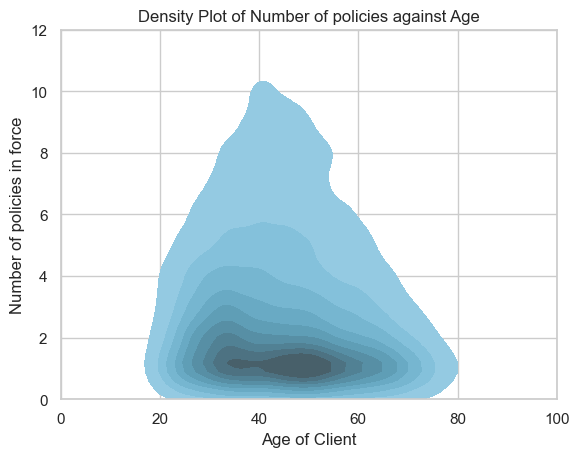

In [256]:
# Density Plot of Number of policies against Age
sns.set(style="whitegrid")
sns.kdeplot(x=data_set_1["cltage"],
            y=data_set_1["tot_inforce_pols"], shade=True, color="skyblue")
plt.xlim(0, 100)
plt.ylim(0, 12)
plt.xlabel("Age of Client")
plt.ylabel("Number of policies in force")
plt.title("Density Plot of Number of policies against Age")
plt.show()

From the density plot, we can observe that a large concentration of clients belong to the 40-60 years old age group and they mostly have only 1 policy in force


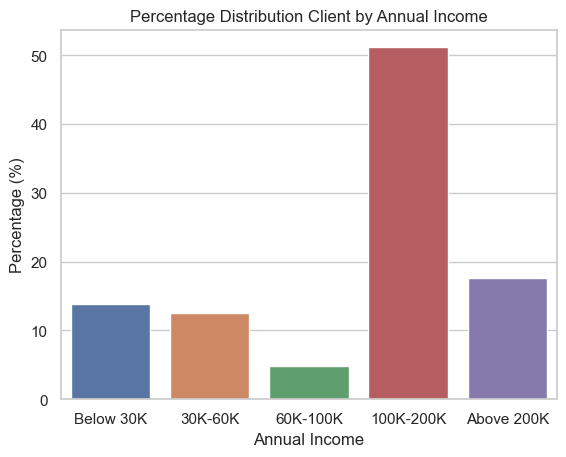

In [265]:
# Bar plot of Client count based on income
percentageIncome = data_set_1['annual_income_est'].value_counts(
    normalize=True) * 100

sns.barplot(x=percentageIncome.index, y=percentageIncome.values)

plt.xlabel('Annual Income')
plt.ylabel('Percentage (%)')
plt.title('Percentage Distribution Client by Annual Income')
plt.show()

As we can see from the bar plot, A large majority of clients also belong to the 100k to 200k income group. Therefore, it might be easier to convert and persuade clients from this income range who are between 40 to 60 years old to sign up for a policy.


In [263]:
data_set_1['annual_income_codes'].value_counts()

 3    7771
-1    2809
 4    2679
 0    2097
 1    1911
 2     725
Name: annual_income_codes, dtype: int64

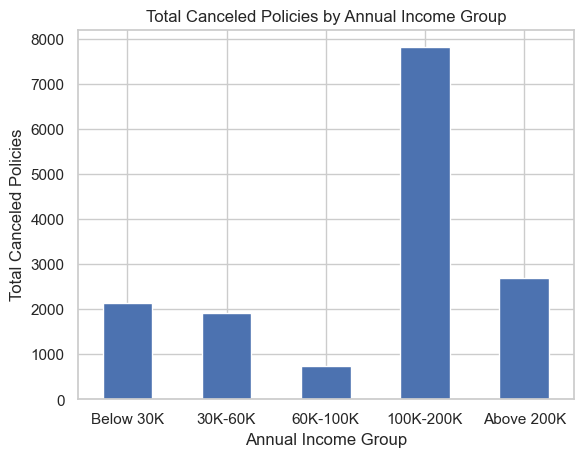

In [273]:
sum_by_income_group = data_set_1.groupby('annual_income_est')[
    'tot_cancel_pols'].sum()

# Plot the result as a bar plot
sum_by_income_group.plot(kind='bar')

# Customize plot labels and title
plt.xlabel('Annual Income Group')
plt.ylabel('Total Canceled Policies')
plt.title('Total Canceled Policies by Annual Income Group')
plt.xticks(rotation=0)

plt.show()

Although a large number of clients belong to the 100k to 200k annual income group, they also have the highest cancellation count. To investigate further, we can visualise the cancellation rate per income group.


In [282]:

# Rate of Policy Cancellation by Income Group
cilentCountByIncome = data_set_1['annual_income_est'].value_counts()
cancellationSum_by_income_group = data_set_1.groupby('annual_income_est')[
    'tot_cancel_pols'].sum()

cancellation_rate_by_income = (
    cancellationSum_by_income_group / cilentCountByIncome)

print(cancellation_rate_by_income)

Below 30K     1.020982
30K-60K       1.006279
60K-100K      1.011034
100K-200K     1.005919
Above 200K    1.008585
dtype: float64


As seen from the table, the cancellation rate between all income groups are seen to be approximately the same. This means that it would be better to find clients that belong to the 100k to 200k income group and are between 40 to 60 years old as they are more likely to sign up for the policy.
